# Family Relations Network Analysis

This notebook provides comprehensive analysis of family relations using network science techniques, including community detection, centrality metrics, and interactive visualizations.

In [8]:
import networkx as nx
from collections import Counter, defaultdict
import community as community_louvain
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community import label_propagation_communities
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
import pandas as pd

# Set visualization style
plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Step 1: Load and Build Network

First, we'll load the family relations data and construct a directed graph representing the relationships.

In [9]:
def load_data(filepath):
    """Load family relations from file"""
    relations = []
    people = set()
    
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 3:
                continue
            
            p1, relation, p2 = parts
            relations.append((p1, relation, p2))
            people.add(p1)
            people.add(p2)
    
    return people, relations

def build_graph(relations):
    """Build a directed graph from relations"""
    G = nx.DiGraph()
    
    for p1, relation, p2 in relations:
        G.add_edge(p1, p2, relation=relation)
    
    return G

# Load data
FILE_PATH = "train.txt"
people, relations = load_data(FILE_PATH)
G = build_graph(relations)

print(f"✓ Network loaded successfully")
print(f"  • Total people: {len(people)}")
print(f"  • Total relations: {len(relations)}")
print(f"  • Graph nodes: {G.number_of_nodes()}")
print(f"  • Graph edges: {G.number_of_edges()}")

✓ Network loaded successfully
  • Total people: 1316
  • Total relations: 13821
  • Graph nodes: 1316
  • Graph edges: 13821


## Step 2: Basic Network Statistics

Get an overview of the network structure and relationship distribution.

In [10]:
def compute_basic_stats(G, relations):
    """Compute basic statistics about the network"""
    stats = {}
    stats["num_people"] = G.number_of_nodes()
    stats["num_relations"] = len(relations)
    stats["relation_distribution"] = Counter([rel for _, rel, _ in relations])
    return stats

stats = compute_basic_stats(G, relations)

# Display summary
display(HTML("<h3>🔍 Network Overview</h3>"))
print(f"People: {stats['num_people']}")
print(f"Relations: {stats['num_relations']}")

# Relationship Distribution
print("\n📊 Top Relationship Types:")
rel_df = pd.DataFrame(
    sorted(stats["relation_distribution"].items(), key=lambda x: x[1], reverse=True),
    columns=['Relationship Type', 'Count']
)
display(
    rel_df.style
    .format({'Count': '{:d}'})
    .set_properties(**{'text-align': 'center'})
)

People: 1316
Relations: 13821

📊 Top Relationship Types:


,Relationship Type,Count
0,grandsonOf,814
1,grandmotherOf,813
2,grandfatherOf,813
3,granddaughterOf,812
4,motherOf,733
5,fatherOf,733
6,sisterOf,636
7,daughterOf,628
8,greatGrandsonOf,624
9,greatGrandmotherOf,617


## Step 3: Centrality Analysis

Identify the most influential and well-connected individuals in the family network using various centrality measures.

In [11]:
def compute_centrality(G):
    """Compute various centrality metrics"""
    UG = G.to_undirected()
    centrality = {}
    centrality["degree"] = nx.degree_centrality(UG)
    centrality["closeness"] = nx.closeness_centrality(UG)
    centrality["betweenness"] = nx.betweenness_centrality(
        UG, k=min(50, len(UG.nodes()))
    )
    return centrality

def top_k(metric_dict, k=10):
    """Get top k items from a metric dictionary"""
    return sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:k]

centrality = compute_centrality(G)

# Degree Centrality
display(HTML("<h4> Top 10 by Degree Centrality</h4>"))
degree_df = pd.DataFrame(top_k(centrality["degree"]), columns=['Person', 'Score'])
display(degree_df.style.format({'Score': '{:.4f}'}).set_properties(**{'text-align': 'center'}))

# Betweenness Centrality
display(HTML("<h4>Top 10 by Betweenness Centrality (Bridge Individuals)</h4>"))
between_df = pd.DataFrame(top_k(centrality["betweenness"]), columns=['Person', 'Score'])
display(between_df.style.format({'Score': '{:.4f}'}).set_properties(**{'text-align': 'center'}))

# Closeness Centrality
display(HTML("<h4> Top 10 by Closeness Centrality</h4>"))
close_df = pd.DataFrame(top_k(centrality["closeness"]), columns=['Person', 'Score'])
display(close_df.style.format({'Score': '{:.4f}'}).set_properties(**{'text-align': 'center'}))

,Person,Score
0,dominik1036,0.0175
1,olivia1043,0.0175
2,magdalena1044,0.0175
3,oliver1045,0.0175
4,lisa1035,0.0175
5,lisa5,0.0167
6,elias6,0.0167
7,nico4,0.0167
8,claudia69,0.0167
9,tobias57,0.0167


,Person,Score
0,marie800,0.0005
1,stefan1192,0.0005
2,elena813,0.0004
3,gertrude97,0.0004
4,lara796,0.0003
5,lena434,0.0002
6,emilia428,0.0002
7,helena1135,0.0002
8,gabriel1140,0.0002
9,dominik789,0.0002


,Person,Score
0,dominik1036,0.0177
1,olivia1043,0.0177
2,magdalena1044,0.0177
3,oliver1045,0.0177
4,lisa1035,0.0177
5,lisa5,0.0171
6,elias6,0.0171
7,nico4,0.0171
8,gabriel146,0.0171
9,oskar133,0.0171


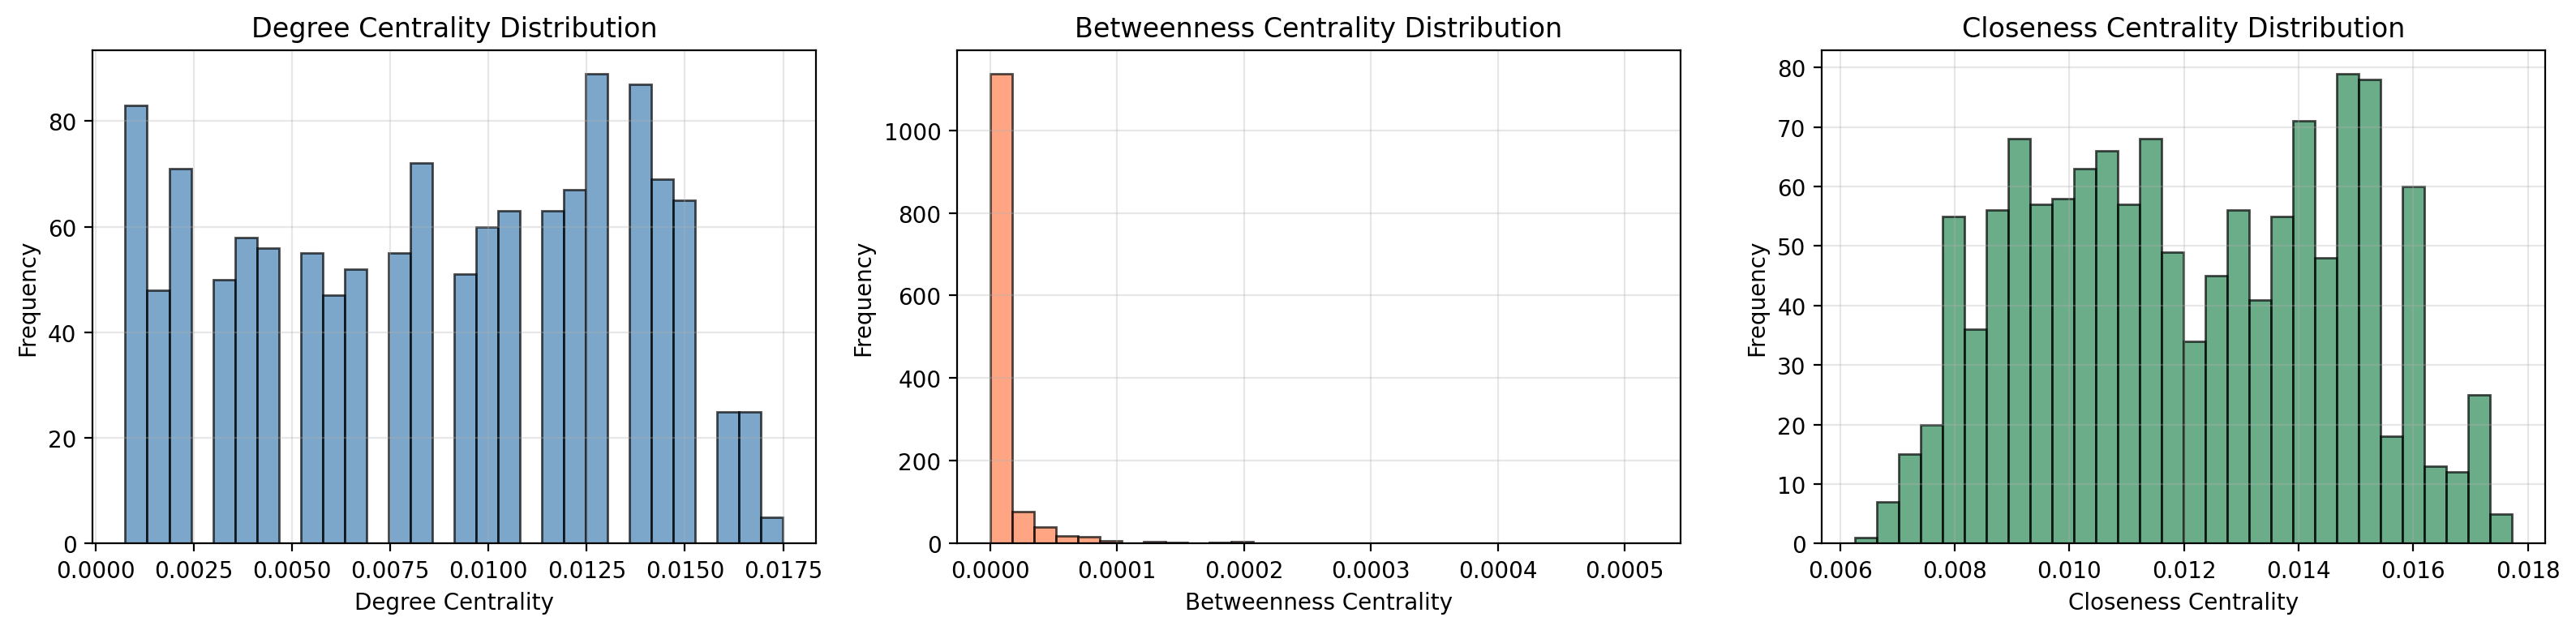

In [12]:
# Visualize centrality distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Degree Centrality Distribution
degree_values = sorted(centrality["degree"].values(), reverse=True)
axes[0].hist(degree_values, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree Centrality')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Centrality Distribution')
axes[0].grid(True, alpha=0.3)

# Betweenness Centrality Distribution
between_values = sorted(centrality["betweenness"].values(), reverse=True)
axes[1].hist(between_values, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Betweenness Centrality')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Betweenness Centrality Distribution')
axes[1].grid(True, alpha=0.3)

# Closeness Centrality Distribution
close_values = sorted(centrality["closeness"].values(), reverse=True)
axes[2].hist(close_values, bins=30, color='seagreen', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Closeness Centrality')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Closeness Centrality Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: Network Structure Analysis

Analyze the overall structure and connectivity properties of the network.

In [13]:
def compute_structure_metrics(G):
    """Compute network structure metrics"""
    UG = G.to_undirected()
    metrics = {}
    
    metrics["density"] = nx.density(UG)
    
    try:
        largest_cc = max(nx.connected_components(UG), key=len)
        subgraph = UG.subgraph(largest_cc)
        
        metrics["largest_component_size"] = subgraph.number_of_nodes()
        metrics["avg_clustering"] = nx.average_clustering(subgraph)
        
        try:
            metrics["diameter"] = nx.diameter(subgraph)
            metrics["avg_path_length"] = nx.average_shortest_path_length(subgraph)
        except:
            metrics["diameter"] = "N/A (too large/disconnected)"
            metrics["avg_path_length"] = "N/A (too large/disconnected)"
    except:
        metrics["largest_component_size"] = 0
        metrics["avg_clustering"] = 0
        metrics["diameter"] = "N/A"
        metrics["avg_path_length"] = "N/A"
    
    return metrics

structure = compute_structure_metrics(G)

# Display structure metrics
display(HTML("<h4>📐 Network Structure Metrics</h4>"))
structure_data = [
    ("Network Density", f"{structure['density']:.4f}"),
    ("Largest Component Size", f"{structure['largest_component_size']} nodes"),
    ("Average Clustering Coefficient", f"{structure['avg_clustering']:.4f}"),
    ("Network Diameter", str(structure['diameter'])),
    ("Average Shortest Path Length", str(structure['avg_path_length']))
]
struct_df = pd.DataFrame(structure_data, columns=['Metric', 'Value'])
display(struct_df.style.set_properties(**{'text-align': 'center'}))

,Metric,Value
0,Network Density,0.0086
1,Largest Component Size,27 nodes
2,Average Clustering Coefficient,0.8418
3,Network Diameter,3
4,Average Shortest Path Length,1.4700854700854702


## Step 5: Community Detection

Identify clusters of closely-related families using different community detection algorithms.

In [14]:
def louvain_communities(G):
    """Detect communities using Louvain algorithm"""
    partition = community_louvain.best_partition(G)
    communities = defaultdict(set)
    for node, cid in partition.items():
        communities[cid].add(node)
    return list(communities.values())

def label_propagation(G):
    """Detect communities using Label Propagation"""
    return list(label_propagation_communities(G))

def evaluate_modularity(G, communities):
    """Compute modularity of communities"""
    return nx_comm.modularity(G, communities)

# Run community detection
UG = G.to_undirected()
louvain_comms = louvain_communities(UG)
louvain_mod = evaluate_modularity(UG, louvain_comms)

lp_comms = label_propagation(UG)
lp_mod = evaluate_modularity(UG, lp_comms)

# Display results
display(HTML("<h4>🔗 Community Detection Results</h4>"))

# Louvain Results
print("Louvain Algorithm:")
print(f"  Number of communities: {len(louvain_comms)}")
print(f"  Modularity: {louvain_mod:.4f}")

# Label Propagation Results
print("\nLabel Propagation Algorithm:")
print(f"  Number of communities: {len(lp_comms)}")
print(f"  Modularity: {lp_mod:.4f}")

# Community size distribution
display(HTML("<h4>📊 Community Size Distribution (Louvain)</h4>"))
comm_sizes = [len(comm) for comm in louvain_comms]
comm_size_df = pd.DataFrame({
    'Community ID': range(len(comm_sizes)),
    'Size': comm_sizes
}).sort_values('Size', ascending=False).reset_index(drop=True)
display(comm_size_df.style.set_properties(**{'text-align': 'center'}))

Louvain Algorithm:
  Number of communities: 50
  Modularity: 0.9794

Label Propagation Algorithm:
  Number of communities: 64
  Modularity: 0.9652


,Community ID,Size
0,0,27
1,5,27
2,13,27
3,7,27
4,31,27
5,30,27
6,45,27
7,47,27
8,39,27
9,43,27


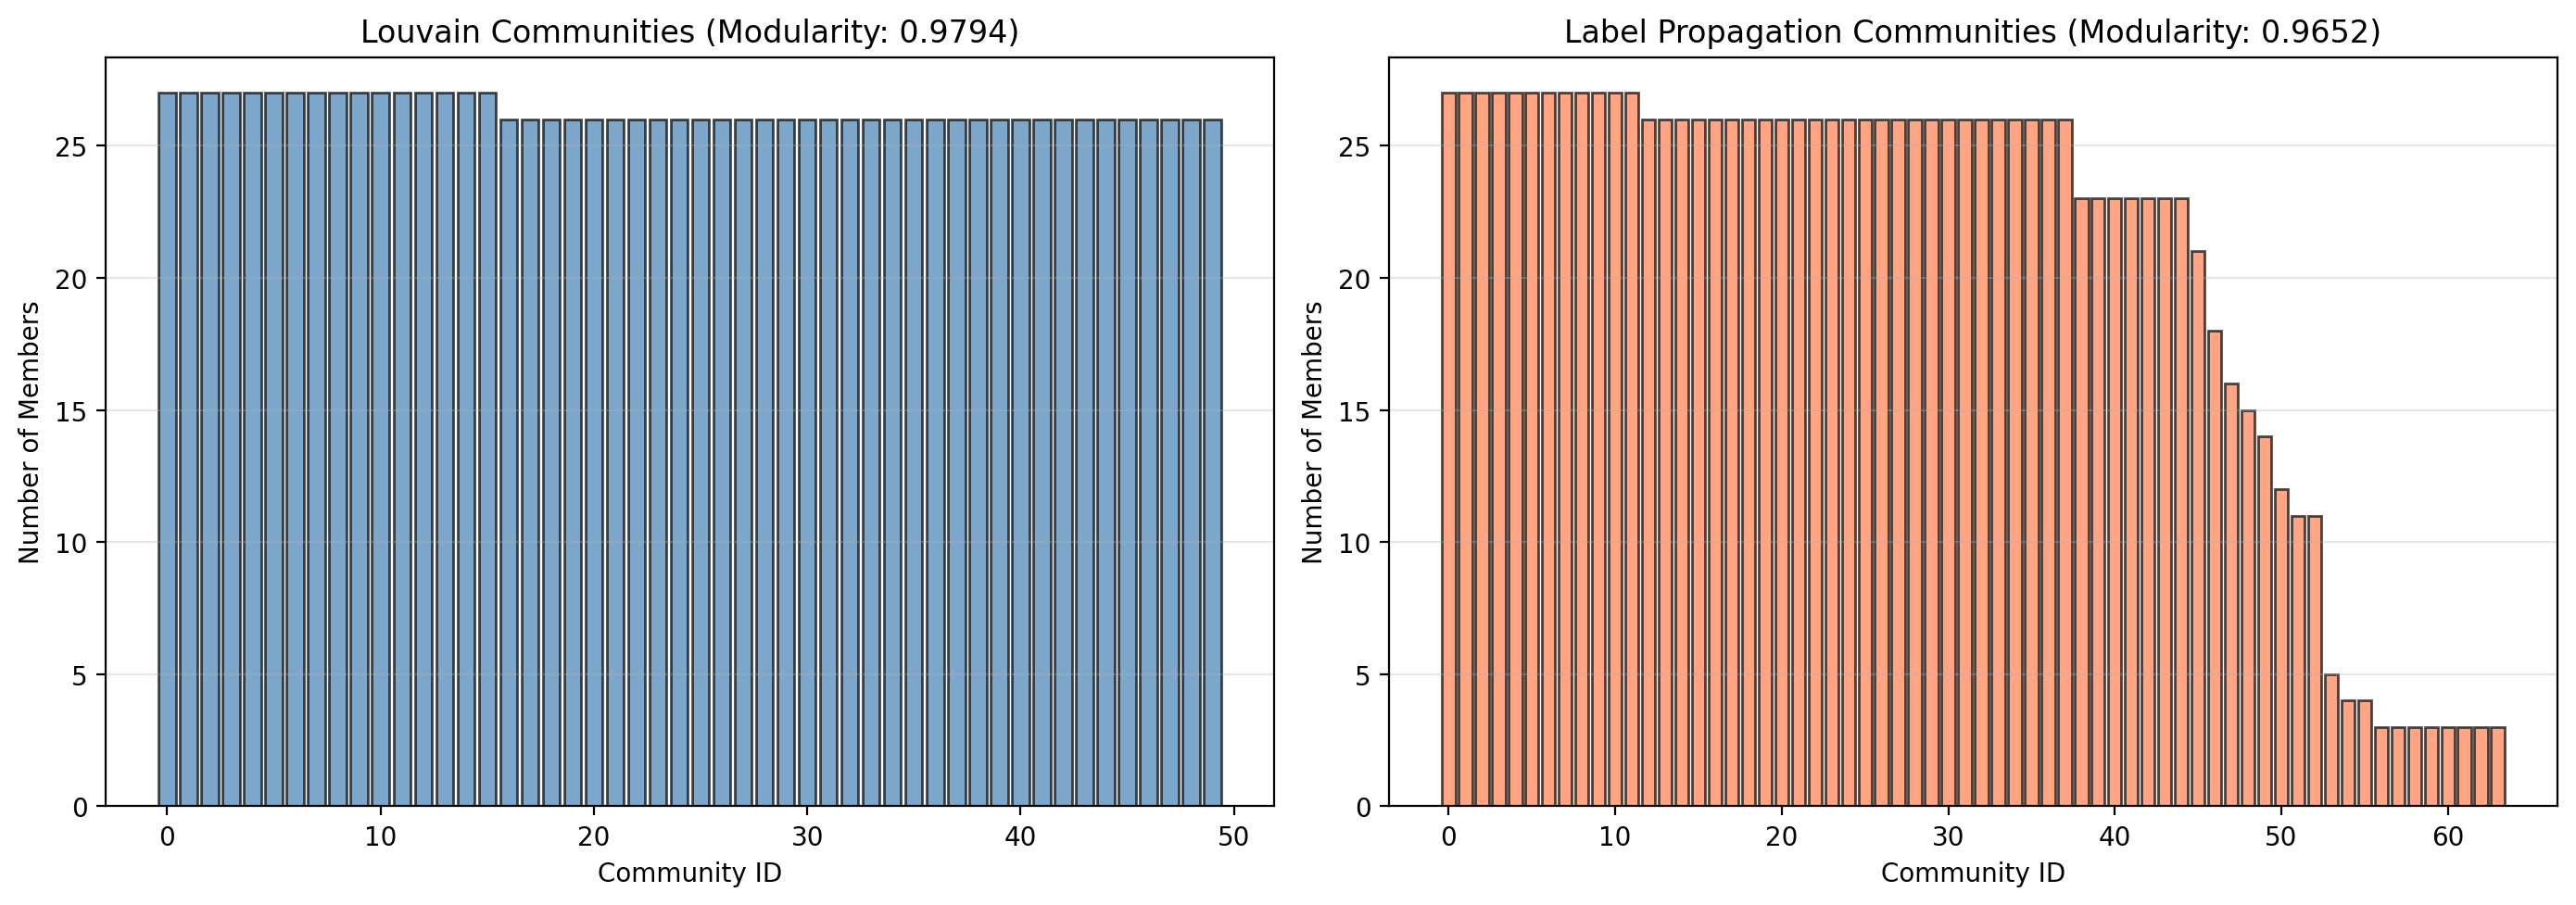

In [15]:
# Visualize community sizes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Louvain community sizes
comm_sizes = sorted([len(comm) for comm in louvain_comms], reverse=True)
axes[0].bar(range(len(comm_sizes)), comm_sizes, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Community ID')
axes[0].set_ylabel('Number of Members')
axes[0].set_title(f'Louvain Communities (Modularity: {louvain_mod:.4f})')
axes[0].grid(True, alpha=0.3, axis='y')

# Label Propagation community sizes
lp_sizes = sorted([len(comm) for comm in lp_comms], reverse=True)
axes[1].bar(range(len(lp_sizes)), lp_sizes, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Community ID')
axes[1].set_ylabel('Number of Members')
axes[1].set_title(f'Label Propagation Communities (Modularity: {lp_mod:.4f})')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Step 6: Network Visualizations

Interactive visualizations of the family network structure.

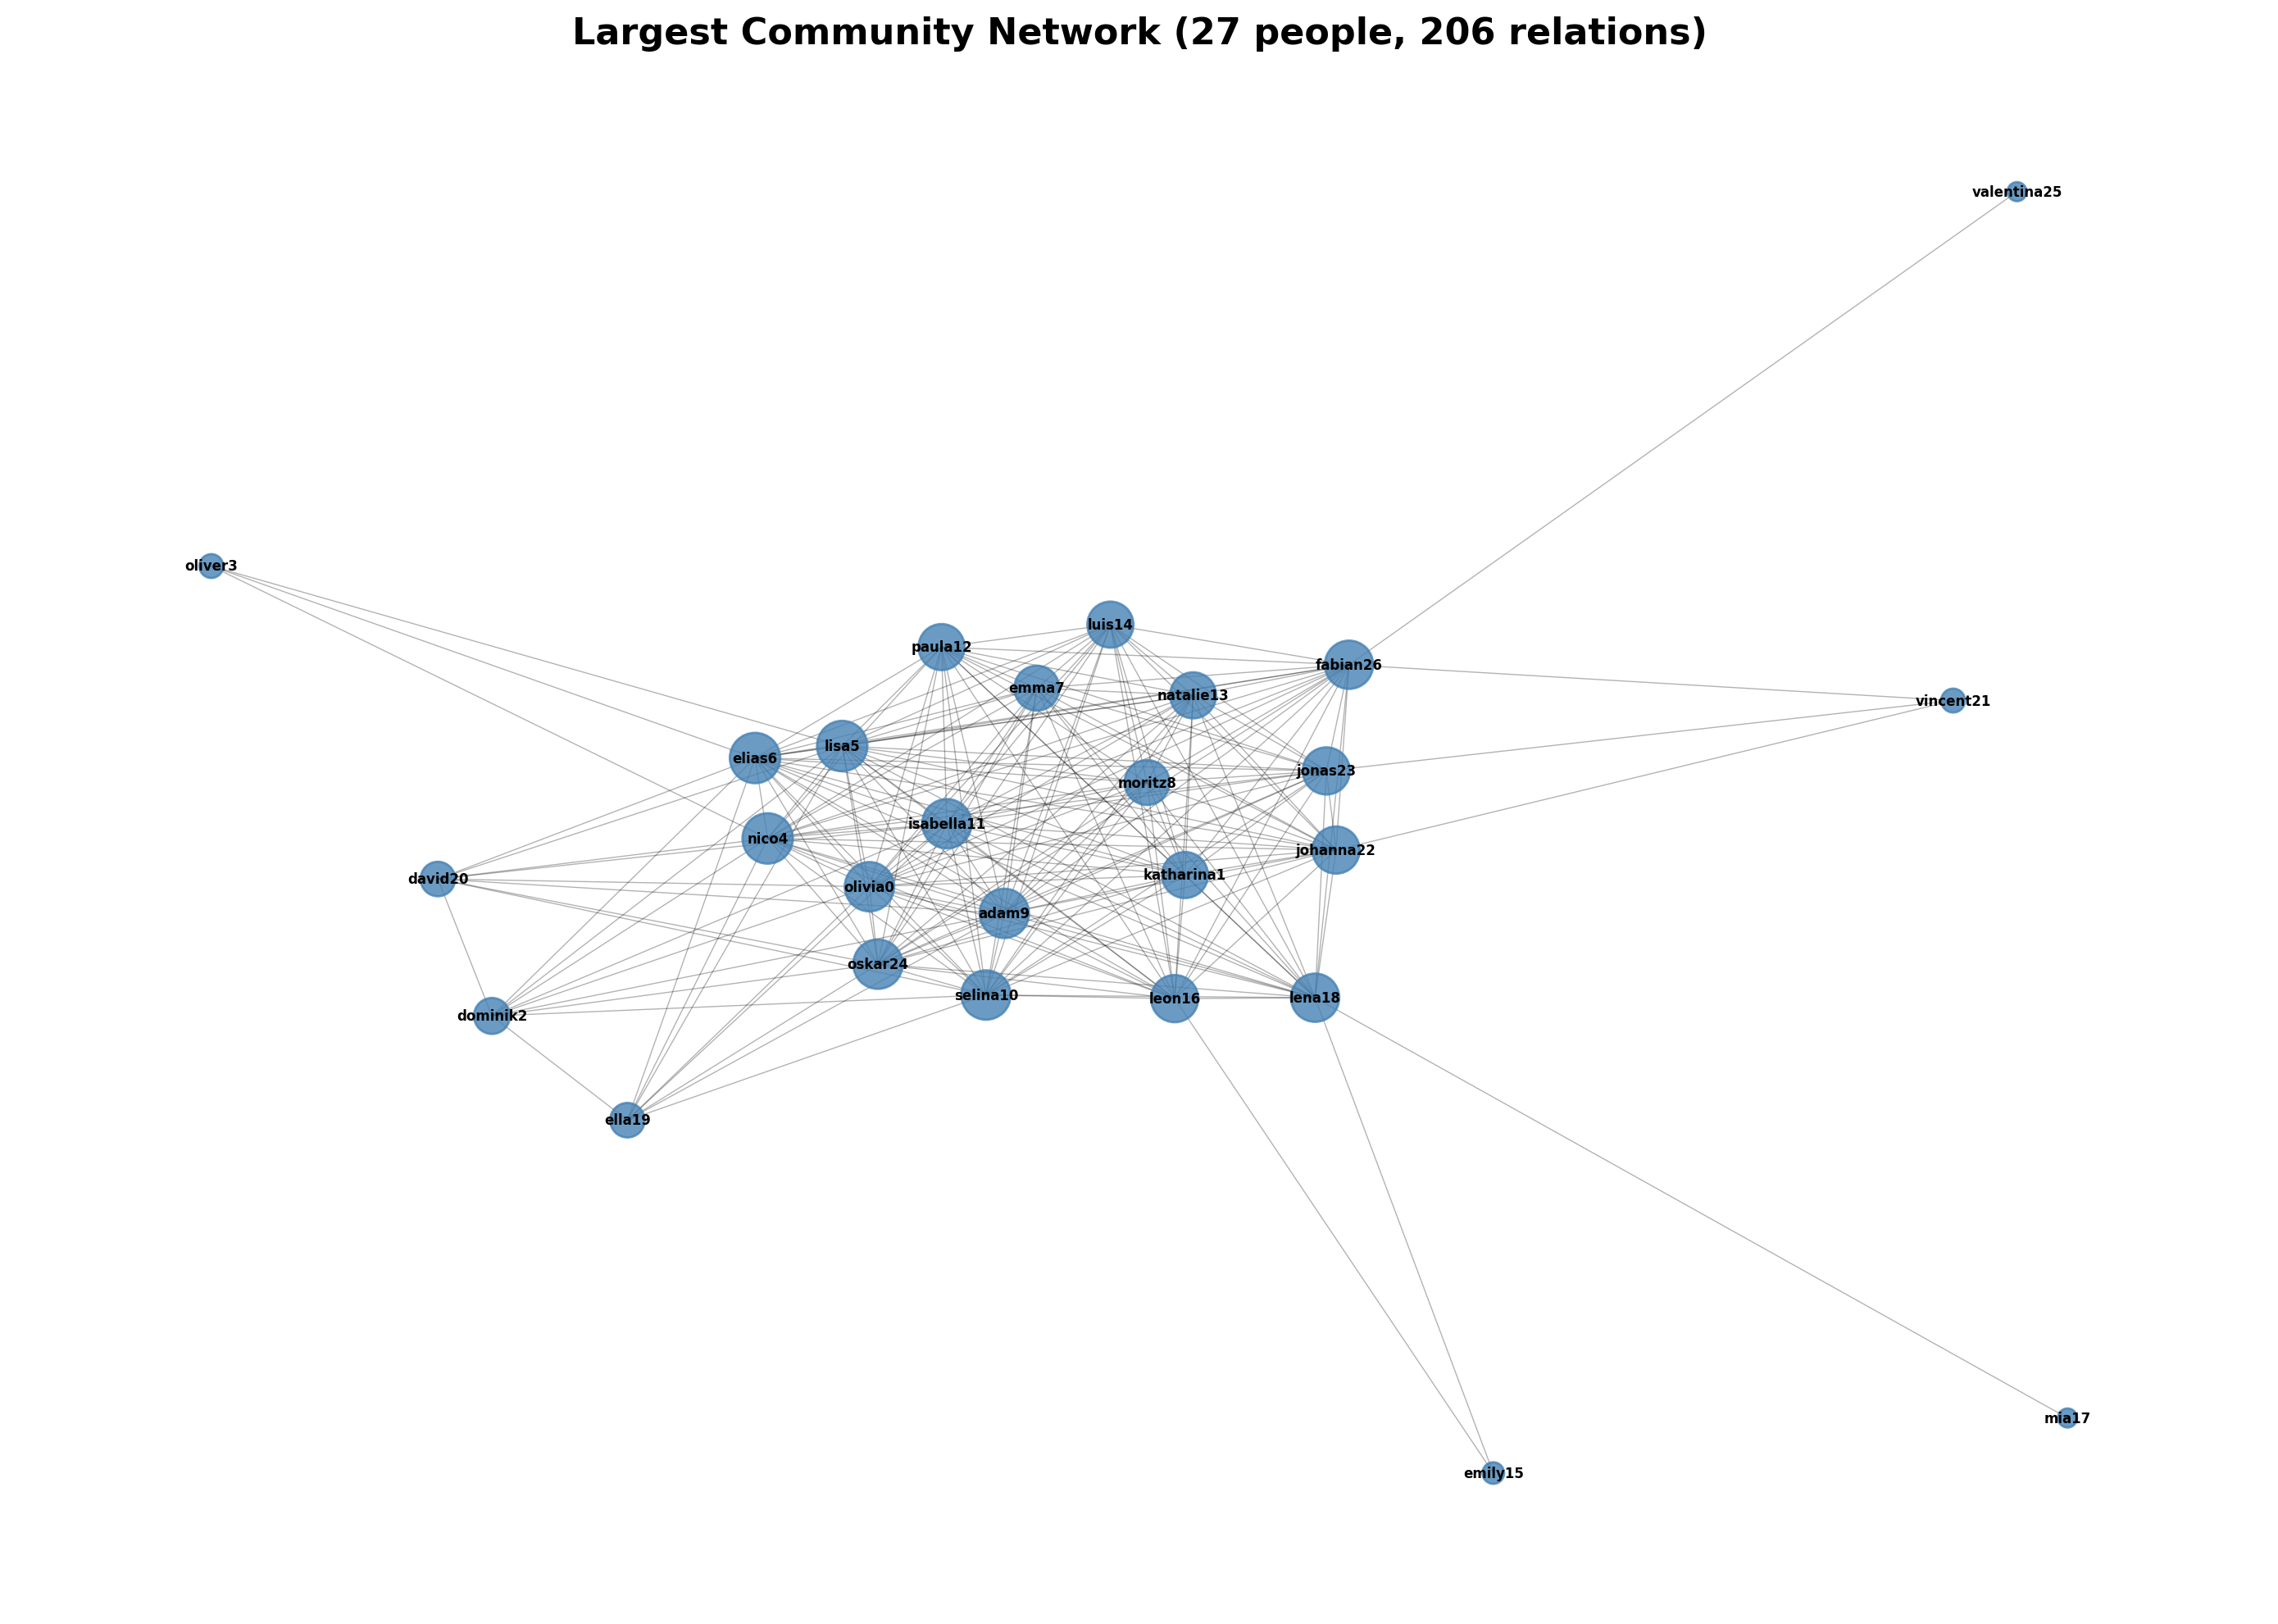

In [16]:
### Largest Community Network

plt.figure(figsize=(14, 10))

largest_comm = max(louvain_comms, key=len)
nodes = list(largest_comm)[:200]  # Limit to 200 nodes for clarity

subG = G.subgraph(nodes).to_undirected()

pos = nx.spring_layout(subG, seed=42, k=0.5, iterations=50)

# Node sizes based on degree
node_sizes = [subG.degree(node) * 20 + 50 for node in subG.nodes()]

# Draw network
nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, node_color='steelblue', alpha=0.8)
nx.draw_networkx_edges(subG, pos, alpha=0.3, width=0.5)
nx.draw_networkx_labels(subG, pos, font_size=6, font_weight='bold')

plt.title(f"Largest Community Network ({len(subG.nodes())} people, {subG.number_of_edges()} relations)", 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

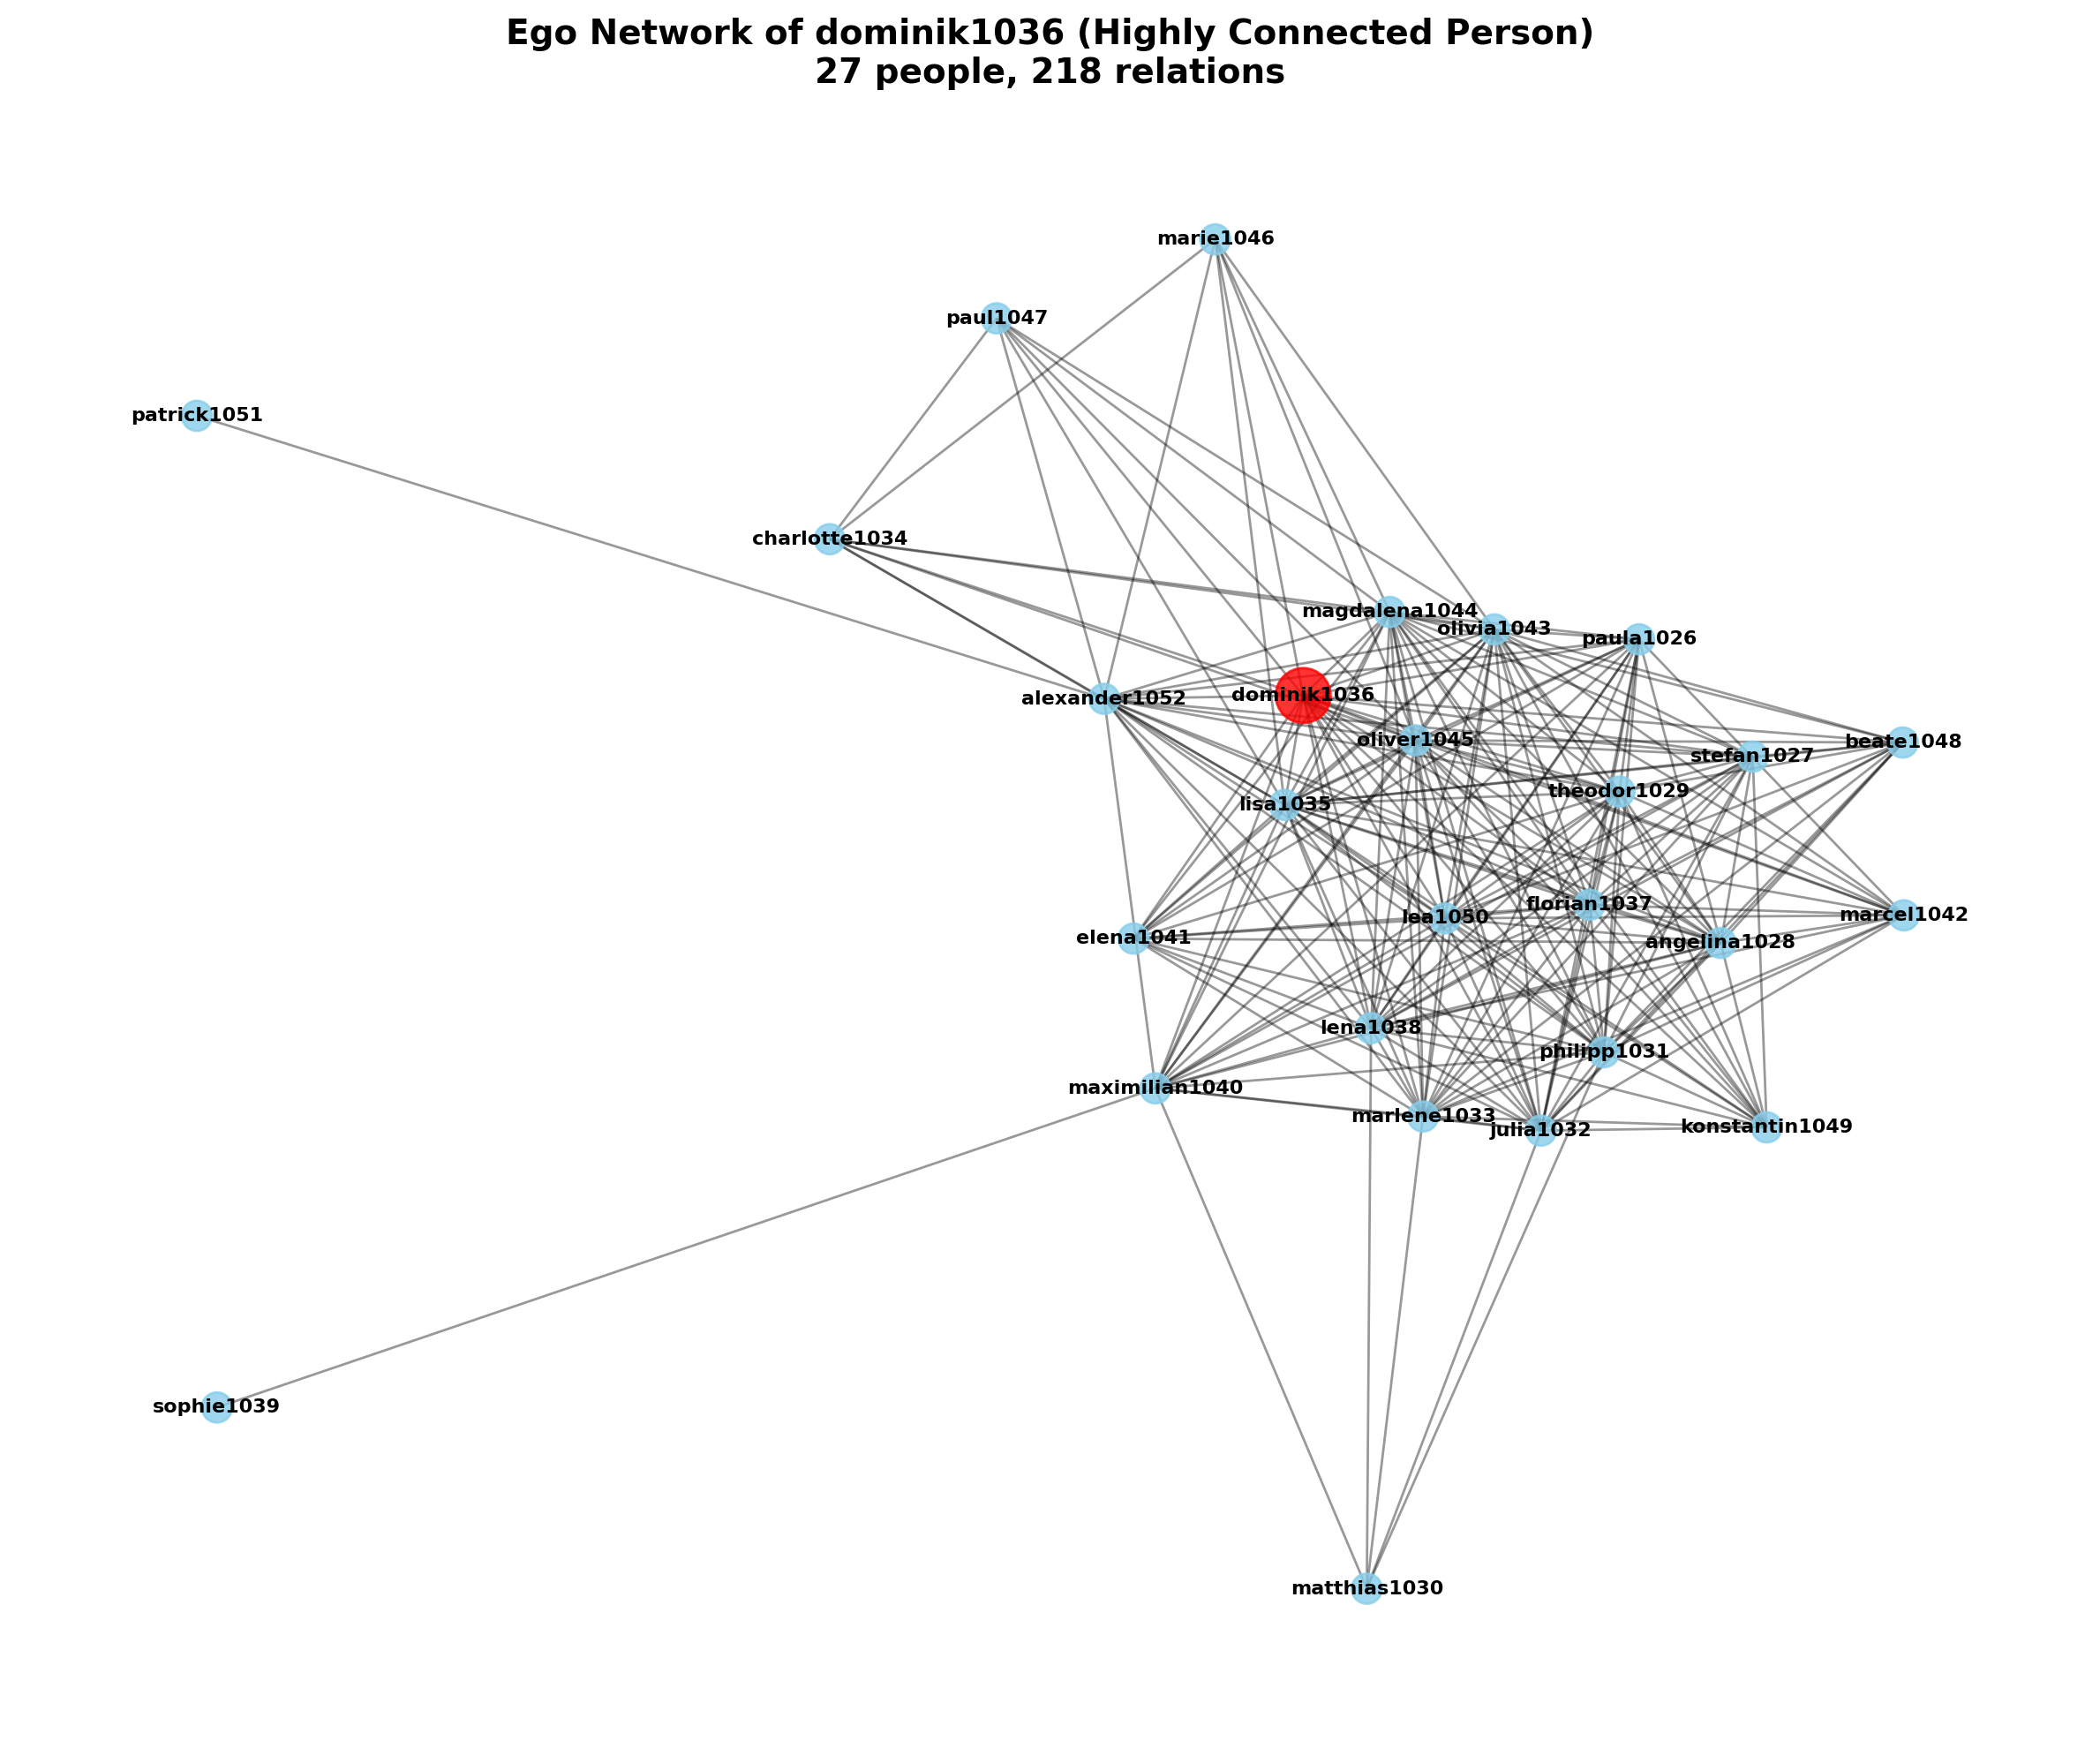

In [17]:
### Ego Network of Most Central Person

# Get the most central person
most_central = max(centrality["degree"].items(), key=lambda x: x[1])[0]

plt.figure(figsize=(12, 10))

ego = nx.ego_graph(G.to_undirected(), most_central, radius=2)

pos = nx.spring_layout(ego, seed=42, k=1)

# Node colors - center person is red, others are blue
node_colors = [
    "red" if node == most_central else "skyblue"
    for node in ego.nodes()
]

# Node sizes based on distance from center
node_sizes = []
for node in ego.nodes():
    if node == most_central:
        node_sizes.append(500)
    else:
        node_sizes.append(150)

nx.draw_networkx_nodes(ego, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(ego, pos, alpha=0.4, width=1)
nx.draw_networkx_labels(ego, pos, font_size=8, font_weight='bold')

plt.title(f"Ego Network of {most_central} (Highly Connected Person)\n{ego.number_of_nodes()} people, {ego.number_of_edges()} relations",
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

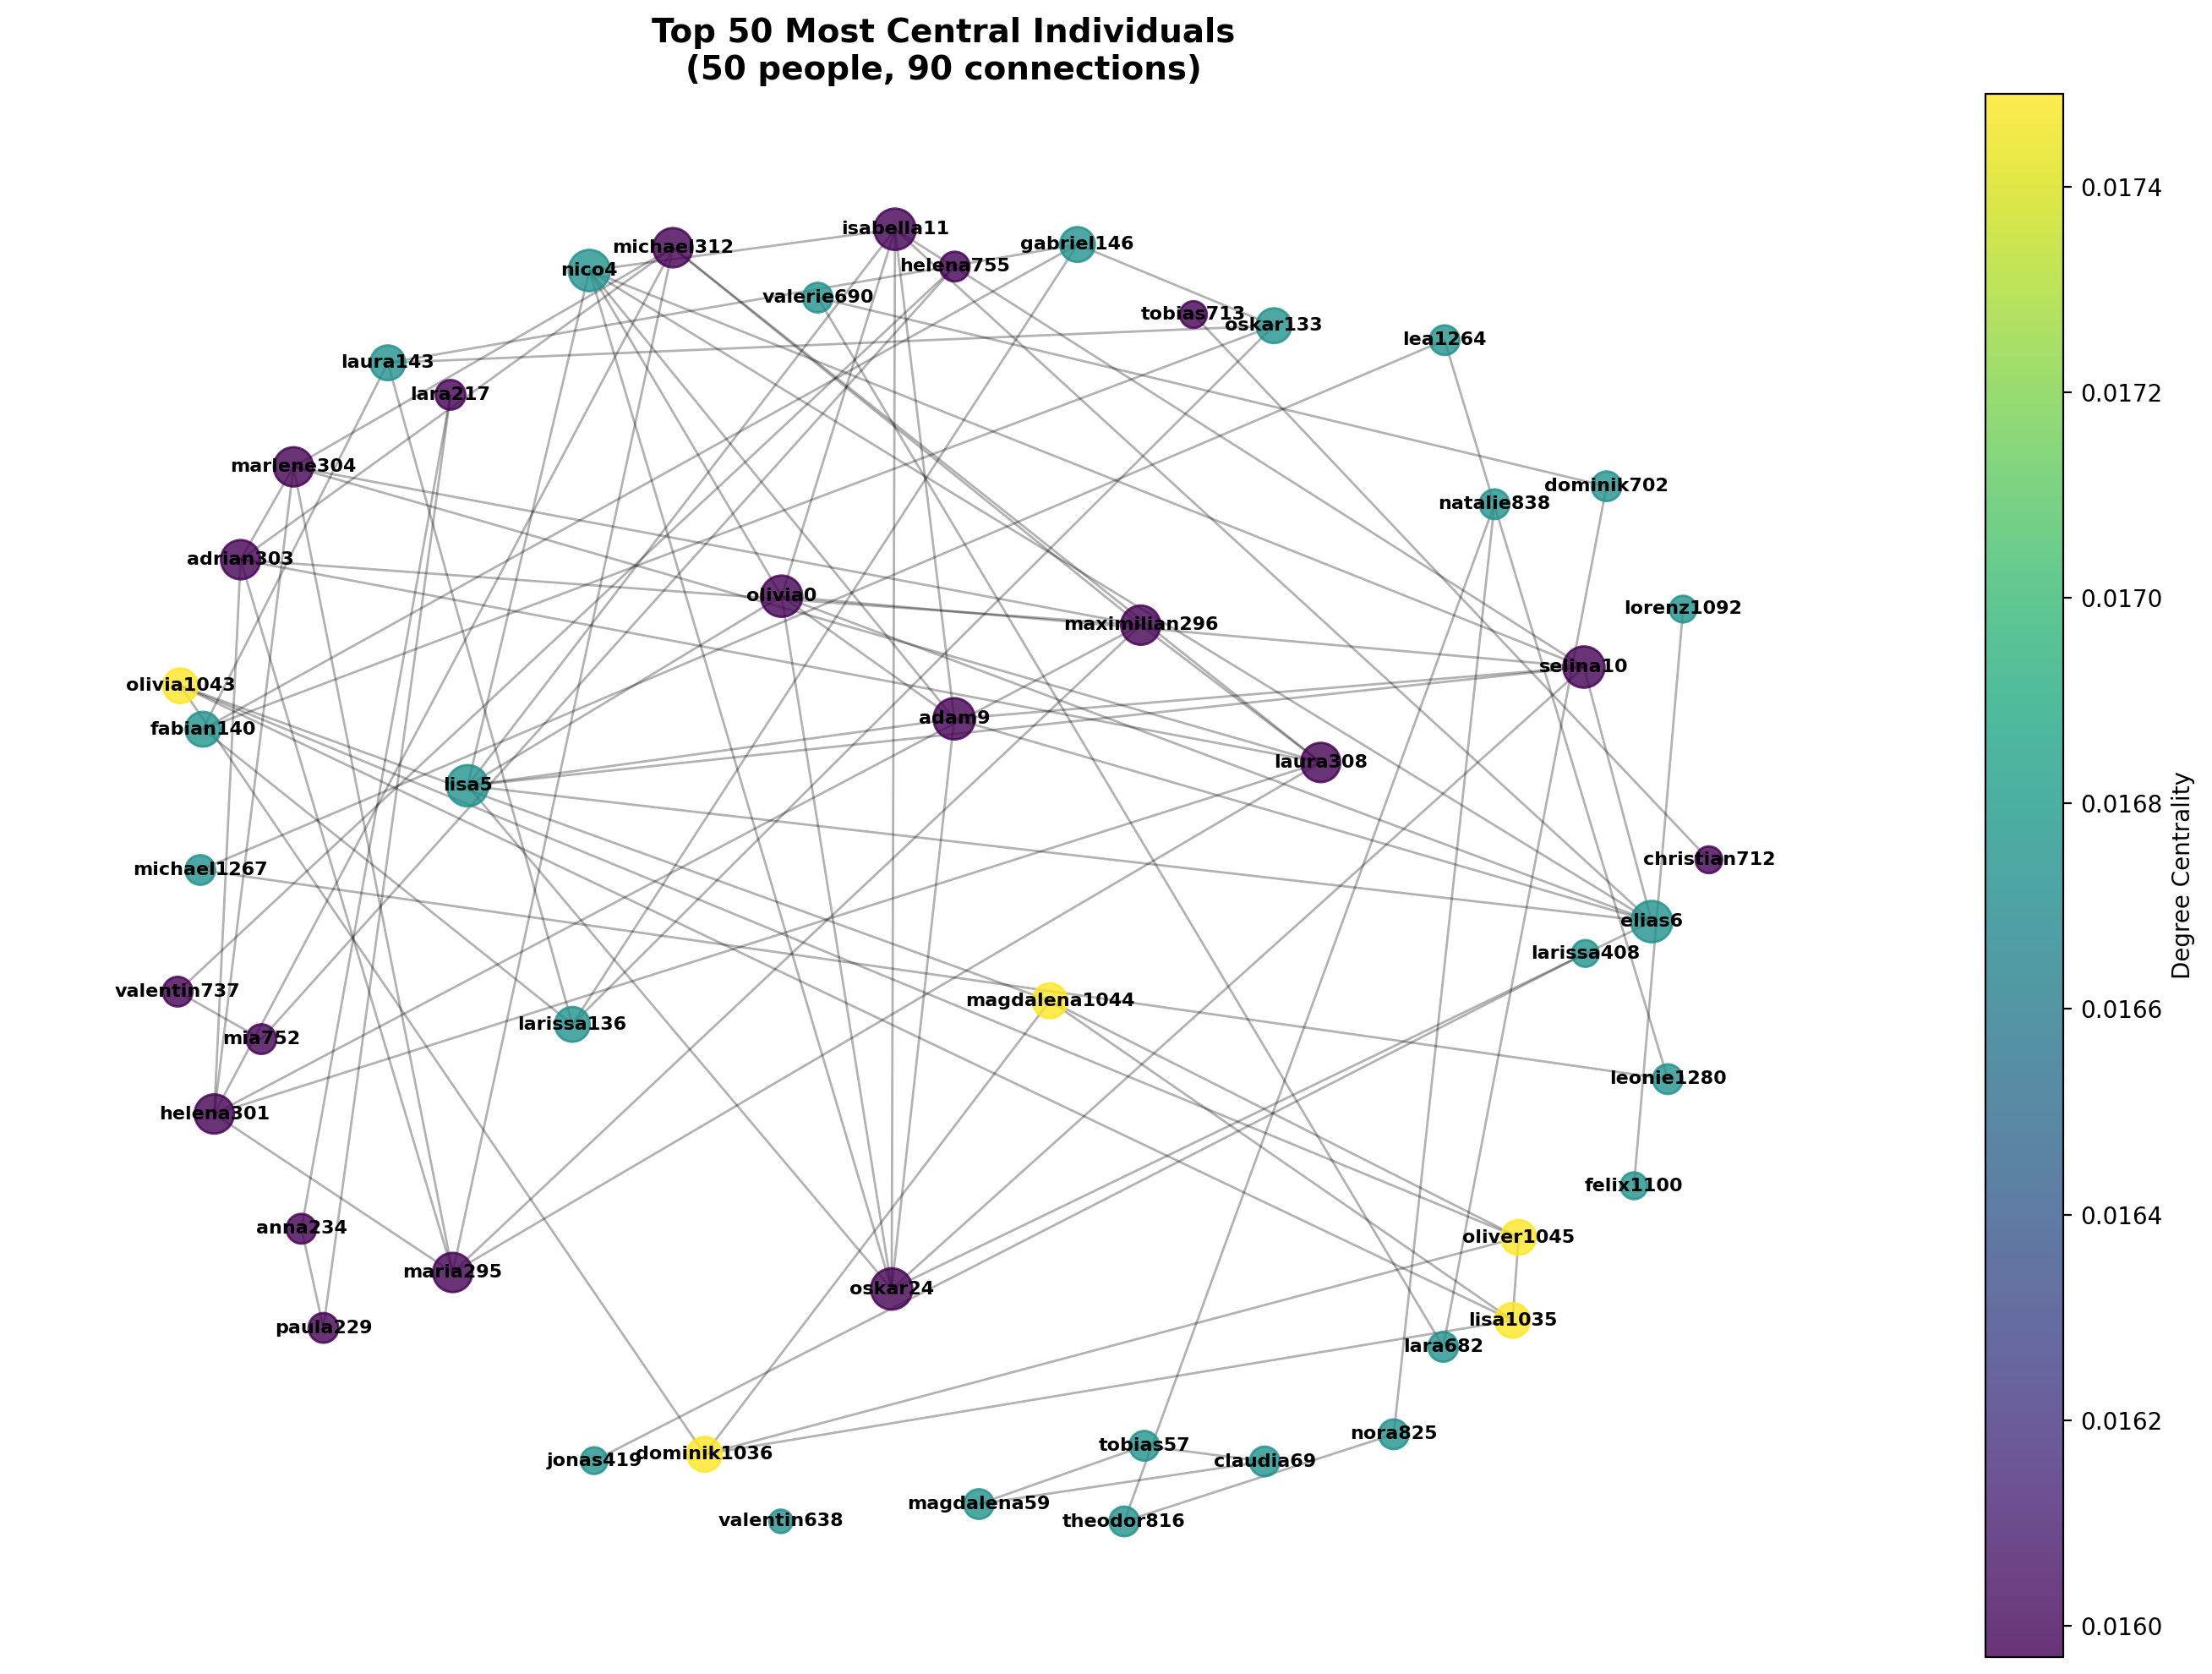

In [18]:
### Top Central Individuals Network

plt.figure(figsize=(14, 10))

top_nodes = [
    node for node, _ in sorted(
        centrality["degree"].items(),
        key=lambda x: x[1],
        reverse=True
    )[:50]
]

subG = G.subgraph(top_nodes).to_undirected()

pos = nx.spring_layout(subG, seed=42, k=2, iterations=50)

# Node sizes based on degree
node_sizes = [subG.degree(node) * 30 + 100 for node in subG.nodes()]

# Node colors based on degree centrality
node_colors = [centrality["degree"][node] for node in subG.nodes()]

nodes = nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, 
                                node_color=node_colors, cmap='viridis', alpha=0.8)
nx.draw_networkx_edges(subG, pos, alpha=0.3, width=1)
nx.draw_networkx_labels(subG, pos, font_size=8, font_weight='bold')

plt.title(f"Top 50 Most Central Individuals\n({subG.number_of_nodes()} people, {subG.number_of_edges()} connections)",
          fontsize=14, fontweight='bold')
plt.axis('off')

# Add colorbar
cbar = plt.colorbar(nodes, ax=plt.gca(), label='Degree Centrality')

plt.tight_layout()
plt.show()

## Step 7: Generation Analysis

Estimate the generational depth within each community based on parent-child relationships.

In [19]:
def estimate_generations(G, communities):
    """Estimate generational depth in each community"""
    parent_edges = [
        (u, v)
        for u, v, d in G.edges(data=True)
        if d.get("relation") in ["fatherOf", "motherOf"]
    ]
    
    parent_graph = nx.DiGraph()
    parent_graph.add_edges_from(parent_edges)
    
    generation_data = []
    
    for i, comm in enumerate(communities[:10]):
        sub = parent_graph.subgraph(comm).copy()
        
        try:
            longest = nx.dag_longest_path_length(sub)
            generation_data.append({
                'Community': i,
                'Generations': longest + 1,
                'Members': len(comm)
            })
        except:
            generation_data.append({
                'Community': i,
                'Generations': '?',
                'Members': len(comm)
            })
    
    return generation_data

generation_data = estimate_generations(G, louvain_comms)

display(HTML("<h4>👨‍👩‍👧‍👦 Generational Depth in Communities</h4>"))
gen_df = pd.DataFrame(generation_data)
display(gen_df.style.set_properties(**{'text-align': 'center'}))

,Community,Generations,Members
0,0,4,27
1,1,6,26
2,2,4,26
3,3,5,26
4,4,6,26
5,5,5,27
6,6,7,26
7,7,4,27
8,8,5,26
9,9,7,26


## Step 8: Relationship Distance Analysis

Analyze the degree of relatedness between individuals using weighted path distances.

In [20]:
RELATION_WEIGHTS = {
    "fatherOf": 1,
    "motherOf": 1,
    "sonOf": 1,
    "daughterOf": 1,
    "brotherOf": 2,
    "sisterOf": 2,
    "uncleOf": 3,
    "auntOf": 3,
    "cousinOf": 4,
}

def build_weighted_graph(relations):
    """Build a weighted graph based on relationship closeness"""
    G = nx.Graph()
    
    for u, rel, v in relations:
        weight = RELATION_WEIGHTS.get(rel, 5)
        G.add_edge(u, v, weight=weight)
    
    return G

def rank_related_people(G, person, top_k=15):
    """Find closest relatives to a person"""
    if person not in G:
        return []
    
    lengths = nx.single_source_dijkstra_path_length(G, person)
    ranked = sorted(lengths.items(), key=lambda x: x[1])
    return ranked[:top_k]

# Build weighted graph
WG = build_weighted_graph(relations)

# Get most central person for analysis
example_person = most_central

ranked = rank_related_people(WG, example_person, top_k=15)

display(HTML(f"<h4>👥 Closest Relatives to {example_person}</h4>"))
rel_df = pd.DataFrame(ranked, columns=['Person', 'Relationship Distance'])
display(rel_df.style.format({'Relationship Distance': '{:.1f}'}).set_properties(**{'text-align': 'center'}))

,Person,Relationship Distance
0,dominik1036,0.0
1,charlotte1034,1.0
2,theodor1029,1.0
3,olivia1043,2.0
4,magdalena1044,2.0
5,oliver1045,2.0
6,lisa1035,2.0
7,marie1046,2.0
8,paul1047,2.0
9,paula1026,2.0


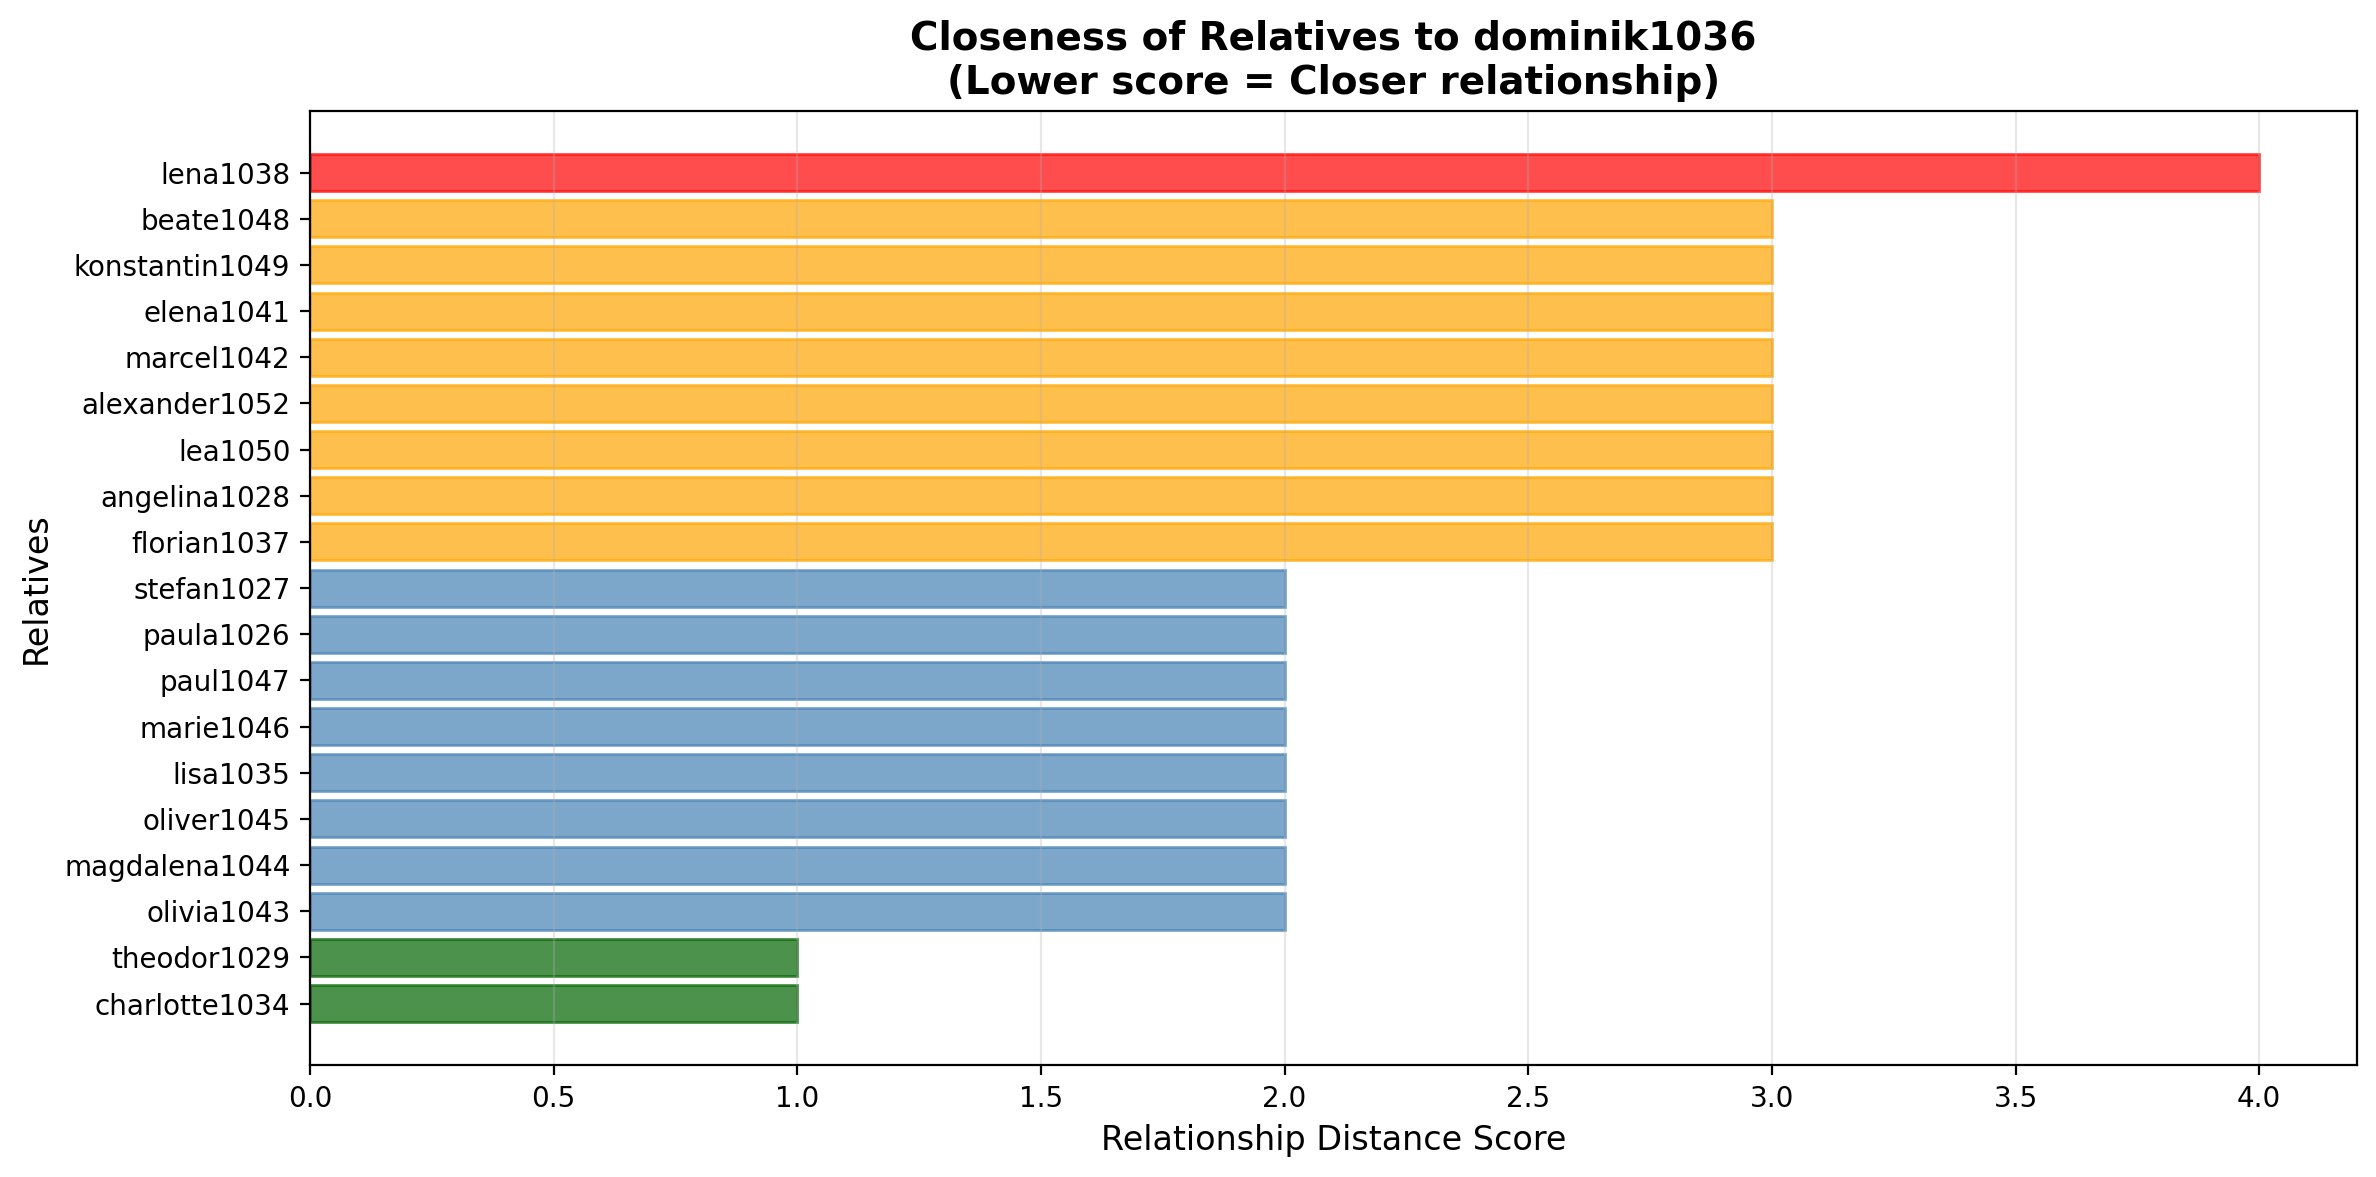

In [21]:
plt.figure(figsize=(12, 6))

# Get top 20 closest relatives
top_relatives = rank_related_people(WG, example_person, top_k=20)[1:]  # Skip the person themselves

names = [r[0] for r in top_relatives]
distances = [r[1] for r in top_relatives]

bars = plt.barh(names, distances, color='steelblue', edgecolor='black', alpha=0.7)

# Color bars by distance
for bar, dist in zip(bars, distances):
    if dist <= 1.5:
        bar.set_color('darkgreen')
    elif dist <= 2.5:
        bar.set_color('steelblue')
    elif dist <= 3.5:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.xlabel('Relationship Distance Score', fontsize=12)
plt.ylabel('Relatives', fontsize=12)
plt.title(f'Closeness of Relatives to {example_person}\n(Lower score = Closer relationship)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()